# CS - 587:  Exercise 4b ~ Saliency Maps

We will use a pretrained model, in our case a VGG_16 to compute class saliency maps as described in Section 3.1 of [1].

A saliency map tells us the degree to which each pixel in the image affects the classification score for that image. To compute it, we compute the gradient of the unnormalized score corresponding to the correct class (which is a scalar) with respect to the pixels of the image. If the image has shape (H, W, 3) then this gradient will also have shape (H, W, 3); for each pixel in the image, this gradient tells us the amount by which the classification score will change if the pixel changes by a small amount. To compute the saliency map, we take the absolute value of this gradient, then take the maximum value over the 3 input channels; the final saliency map thus has shape (H, W) and all entries are nonnegative.

[1] [Karen Simonyan, Andrea Vedaldi, and Andrew Zisserman. "Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps", ICLR Workshop 2014](https://arxiv.org/abs/1312.6034).

In [1]:
import os
import json
import torch
# import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torchvision.transforms as transforms
import torchvision.models as models


# Load the ImageNet class labels
with open('imagenet_class_index.json') as f:
    class_idx = json.load(f)
    idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]

Load the pretrained model (VGG16)

In [3]:
########################################################################################
# TODO: Define the model (VGG16 pretrained on ImageNet 1K)                             #
#       and turn off the calculation of the gradients w.r.t.                           #
#       the weights of the model (hint: requires_grad=False)                           #
# hint: https://pytorch.org/vision/main/models/generated/torchvision.models.vgg16.html #
########################################################################################
vgg16_weights = models.VGG16_Weights.IMAGENET1K_V1
vgg16 = models.vgg16(weights=vgg16_weights)
vgg16.eval()

for param in vgg16.parameters():
    param.requires_grad = False

print(vgg16)          # Uncomment to see the architecture of the model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Load the input image and preprocess it

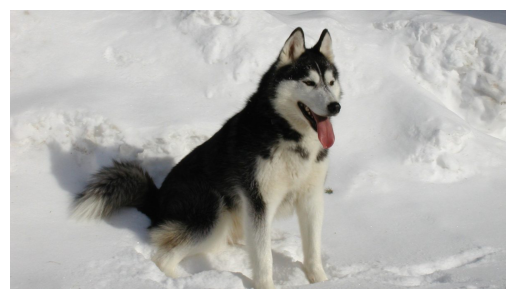

tensor([[[[1.3413, 1.3584, 1.3413,  ..., 0.8104, 0.7933, 0.8276],
          [1.3584, 1.3584, 1.3584,  ..., 1.0673, 0.9303, 0.8447],
          [1.3413, 1.3584, 1.3755,  ..., 1.3070, 1.2557, 1.1700],
          ...,
          [1.1187, 1.0844, 1.0844,  ..., 1.1187, 1.1529, 1.1187],
          [1.1187, 1.0673, 1.0159,  ..., 1.1529, 1.1358, 1.1187],
          [1.0844, 1.0159, 0.9646,  ..., 1.1529, 1.1529, 1.1358]],

         [[1.5007, 1.5182, 1.5007,  ..., 0.9580, 0.9405, 0.9755],
          [1.5182, 1.5182, 1.5182,  ..., 1.2206, 1.0805, 0.9930],
          [1.5007, 1.5182, 1.5357,  ..., 1.4657, 1.4132, 1.3256],
          ...,
          [1.2731, 1.2381, 1.2381,  ..., 1.2731, 1.3081, 1.2731],
          [1.2731, 1.2206, 1.1681,  ..., 1.3081, 1.2906, 1.2731],
          [1.2381, 1.1681, 1.1155,  ..., 1.3081, 1.3081, 1.2906]],

         [[1.7163, 1.7337, 1.7163,  ..., 1.1759, 1.1585, 1.1934],
          [1.7337, 1.7337, 1.7337,  ..., 1.4374, 1.2980, 1.2108],
          [1.7163, 1.7337, 1.7511,  ..., 1

In [5]:
preprocess = vgg16_weights.transforms()

filename = 'husky'
img = Image.open(os.path.join('images', f'{filename}.jpg')).convert('RGB')

plt.imshow(img)
plt.axis('off')
plt.show()

#####################################################
# TODO: Preprocess the input image and enable       #
# the calculation of the gradients w.r.t. the image #
#####################################################
img_processed = preprocess(img).unsqueeze(0)
img_processed.requires_grad_()

## Class Saliency Map

In order to compute the saliency map of a specific class the following steps are required:

1. Do a forward pass of the preprocessed image through the network.
2. Calculate the scores for every class.
3. Find the derivative of score S at last layer for the class C with the highest prediction.
4. Backpropagate this derivative till the start.
5. Render the gradients and you have your Saliency Map!


Model prediction: Eskimo_dog (id:248)


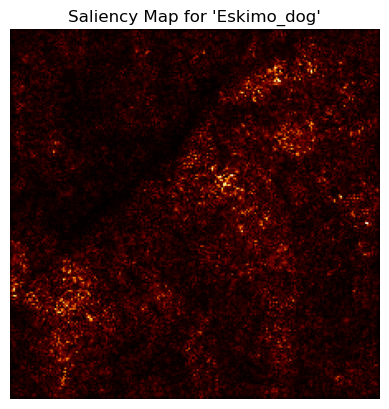

In [6]:
def saliency(model, img_preprocessed):
    ######################################################################################
    # TODO: Implement entire Saliency computation pipeline by:                           #
    #              a) Computing steps 1 and 2                                            #
    #           TODO a.1) Do a forward pass of the image through the model               #
    #           TODO a.2) Calculate the scores for every class.                          #
    #              b) Moving to steps 3 and 4                                            #
    #           TODO  b.1) Take the logit for the specific class                         #
    #                      (the one that gives the highest prediction)                   #
    #           TODO  b.2) Call 'backward' to compute gradients                          #
    #           TODO  b.3) Compute the gradient mask for the class, by taking the        #
    #                      maximum value of the absolute gradient of the image           #
    #                      across the color channels.                                    #
    #           TODO  b.4) visualize the Saliency Map                                    #
    #                                                                                    #
    ######################################################################################
    model.eval()
    # a) forward pass
    model.zero_grad()
    scores = model(img_preprocessed)

    # b1) find the index and score of the target class (the one that gives the highest prediction)
    max_score, max_index = scores.max(dim=1)
    
    id = max_index.item()
    class_name = idx2label[id]
    print(f"Model prediction: {class_name} (id:{id})")

    # b2) call backward to compute gradients
    max_score.backward()

    # b3) get the gradient mask for the specific class
    saliency = img_preprocessed.grad.data.abs()
    saliency, _ = torch.max(saliency, dim=1)

    # normalization to [0, 1]
    saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min())
    return saliency.squeeze().numpy(), class_name


saliency_map, predicted_class = saliency(vgg16, img_processed)

# b4) visualize the Saliency Map
# some code is provided, but you can modify it to make the visualization better
plt.figure()
plt.imshow(saliency_map, cmap=plt.cm.afmhot)
plt.axis('off')
plt.title(f"Saliency Map for '{predicted_class}'")
plt.show()


Processing image: cat


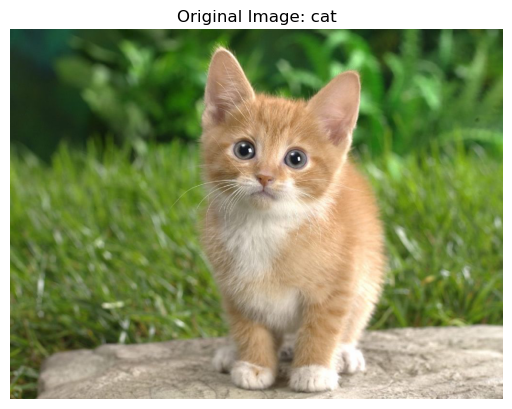

Model prediction: Egyptian_cat (id:285)


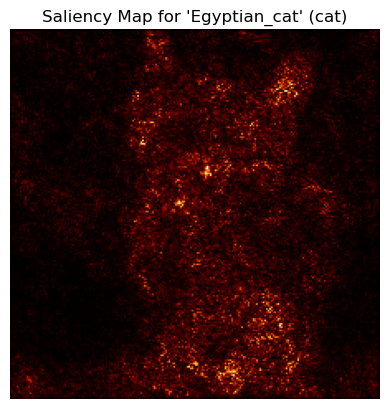


Processing image: doberman


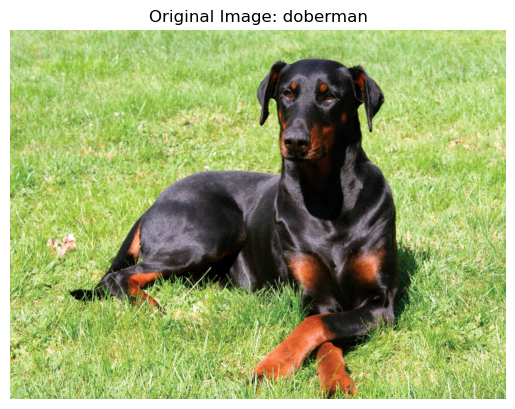

Model prediction: Doberman (id:236)


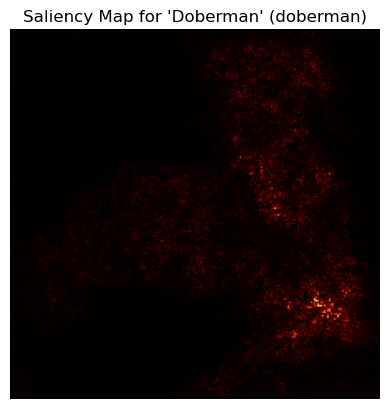


Processing image: flamingo


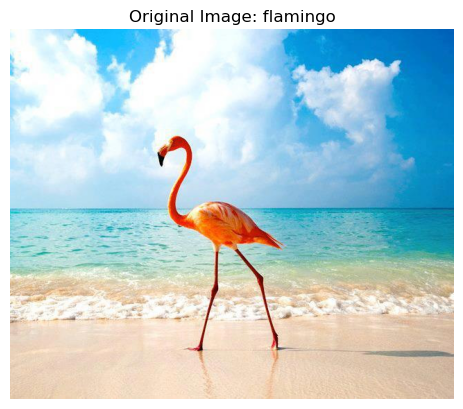

Model prediction: seashore (id:978)


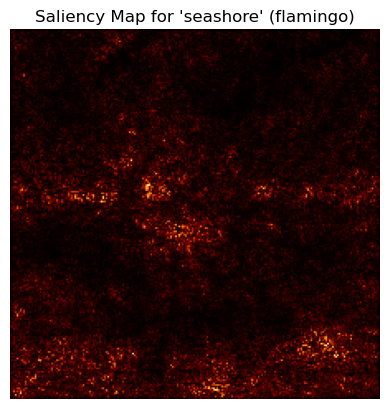


Processing image: husky


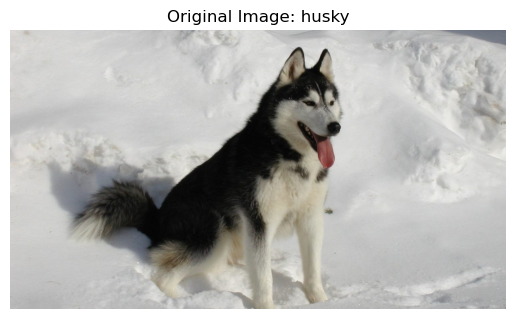

Model prediction: Eskimo_dog (id:248)


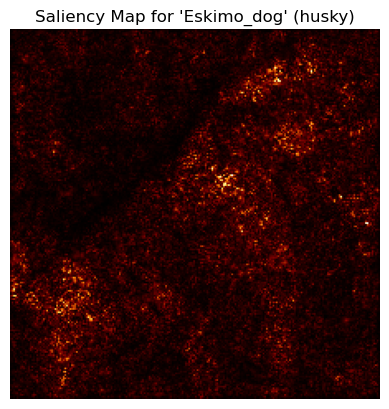


Processing image: teddy


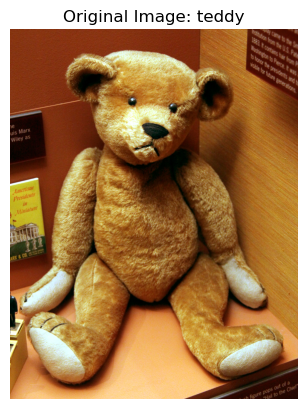

Model prediction: teddy (id:850)


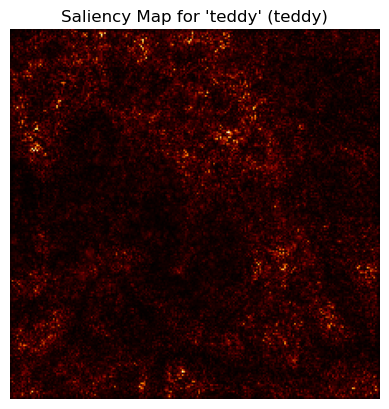

In [11]:
######################################################################################
# TODO: Repeat the process for the rest of images, located in folder = images        #
#              a) Load them and create the tensor to hold them (i.e. correct shape)  #
#              b) Repeat the steps in previous task for ALL new images               #
#              c) Show predicted class for each image and plot Saliency Map          #
######################################################################################
import glob

imageDir = 'images'
imagePaths = glob.glob(os.path.join(imageDir, '*.jpg'))

for path in imagePaths:
    filename = os.path.splitext(os.path.basename(path))[0]
    print(f"\nProcessing image: {filename}")

    img = Image.open(path).convert('RGB')
    plt.figure()
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Original Image: {filename}")
    plt.show()

    imgProcessed = preprocess(img).unsqueeze(0)
    imgProcessed.requires_grad_()

    saliencyMap, predictedClass = saliency(vgg16, imgProcessed)

    plt.figure()
    plt.imshow(saliencyMap, cmap=plt.cm.afmhot)
    plt.axis('off')
    plt.title(f"Saliency Map for '{predictedClass}' ({filename})")
    plt.show()